In [31]:
import glob
import time
import timeit
import pickle
import requests
import json
import re
import numpy as np
import pandas as pd
from multiprocessing import Pool
from matplotlib import pyplot as plt
from zipfile import ZipFile
import lxml.etree as etree
import xmlschema
from pprint import pprint

# If 'get_career' is a custom module you've created, keep this import
from get_career import *

# Define 'toc' function once
def toc(start_time):
    elapsed = timeit.default_timer() - start_time
    print(elapsed)

# Record start time
start_time = timeit.default_timer()

import math


In [4]:
# import pickle 
# path_career='/mnt/sdb1/sandeep/5. NSF vs ERC/data/'
# with open(path_career+'list_ERC_projects.pkl', 'wb') as f:
#     pickle.dump(list_ERC_projects, f)   


In [5]:
# path_career='/mnt/sdb1/sandeep/5. NSF vs ERC/data/'
# with open(path_career+'list_ERC_projects.pkl', 'rb') as f:
#     list_ERC_projects=pickle.load(f)    

In [34]:
url='https://api.openalex.org/works?filter=institutions.id:I198945027'
headers = {
        'User-Agent': 'chowdhary_sandeep',
        'From': 'chowdhary_sandeep@phd.ceu.edu'  # This is another valid field
    }

        
cursor='*'
works_=[];it=0
response = requests.get(url+'&per-page=200&cursor='+cursor,headers=headers)
res = json.loads(response.content.decode("utf-8"))
works_.append(res)
totalpages=math.ceil(x['meta']['count']/200)

while not(res['meta']['next_cursor'] is None):
    it+=1
    print(it/totalpages,end='\r')
    cursor=res['meta']['next_cursor']
    try:
        response = requests.get(url+'&per-page=200&cursor='+cursor,headers=headers)
        response.raise_for_status()  # raises exception when not a 2xx response

    except:
        response = requests.get(url+'&per-page=50&cursor='+cursor,headers=headers)
        response.raise_for_status()  # raises exception when not a 2xx response
    if response.status_code != 204:
#                             res= response.json()                            
        res = json.loads(response.content.decode("utf-8"))

        if len(res['results'])>0:
            works_.append(res)

In [77]:
papers=[works['results'] for works in works_]

In [78]:
papers=np.concatenate(papers)

In [42]:
len(papers)

3812

In [ ]:
# with open(path_career+'CEUworks.pkl', 'wb') as f:
#     pickle.dump(papers, f)


In [59]:
# papers[0]

In [122]:
def extract_paper_details(papers):
    pubyears = []
    institutions = []
    countries = []

    for paper in papers:
        # Extract publication year
        pubyears.append(paper.get('publication_year', None))

        # Extract country codes and institutions
        paper_countries = []
        paper_institutions = []
        for authorship in paper.get('authorships', []):
            for inst in authorship.get('institutions', []):
                if 'country_code' in inst:
                    paper_countries.append(inst['country_code'])
                if 'display_name' in inst:
                    paper_institutions.append(inst['display_name'])

        countries.append(paper_countries)
        institutions.append(paper_institutions)

    return pubyears, institutions, countries


pubyears, institutions, countries = extract_paper_details(papers)

# Now you have three lists: pubyears, institutions, and countries


In [123]:
import numpy as np

def calculate_austrian_collaboration_fraction_and_team_size(institutions, countries):
    austrian_collaboration_fractions = []
    team_sizes = []

    for paper_inst, paper_countries in zip(institutions, countries):
        # Check for None values or length mismatch
        if paper_inst is None or paper_countries is None or len(paper_inst) != len(paper_countries):
            austrian_collaboration_fractions.append(np.nan)
            team_sizes.append(np.nan)
            continue

        # Filter out Central European University and count team size
        filtered_institutions = [inst for inst in paper_inst if 'central european university' not in inst.lower()]
        total_collaborators = len(filtered_institutions)
        team_sizes.append(total_collaborators)

        # Count the number of Austrian collaborators
        austrian_collaborators = sum(1 for inst, country in zip(paper_inst, paper_countries)
                                     if inst is not None and country is not None
                                     and 'AT' in country
                                     and 'central european university' not in inst.lower())

        # Calculate the fraction
        fraction = austrian_collaborators / total_collaborators if total_collaborators else np.nan
        austrian_collaboration_fractions.append(fraction)

    return austrian_collaboration_fractions, team_sizes


fractions, team_sizes = calculate_austrian_collaboration_fraction_and_team_size(institutions, countries)

# 'fractions' contains the calculated measure for each paper
# 'team_sizes' contains the team size for each paper


In [124]:
fractions=np.array(fractions)

In [125]:
len(fractions[fractions>0])

140

In [153]:
import numpy as np

def calculate_collaboration_stats(pubyears, institutions, countries, country_code):
    collaboration_fractions = []
    team_sizes = []
    pre_post_stats = {
        'pre2019': {'fraction': 0, 'total_papers': 0, 'papers_with_collaboration': 0},
        'post2019': {'fraction': 0, 'total_papers': 0, 'papers_with_collaboration': 0}
    }

    for year, paper_inst, paper_countries in zip(pubyears, institutions, countries):
        # Check for None values or length mismatch
        if paper_inst is None or paper_countries is None or len(paper_inst) != len(paper_countries):
            collaboration_fractions.append(np.nan)
            team_sizes.append(np.nan)
            continue

        # Filter out Central European University and count team size
        filtered_institutions = [inst for inst in paper_inst if 'central european university' not in inst.lower()]
        total_collaborators = len(filtered_institutions)
        team_sizes.append(total_collaborators)

        # Count the number of specific country collaborators
        collaborators = sum(1 for inst, country in zip(paper_inst, paper_countries)
                            if inst is not None and country is not None
                            and country_code in country
                            and 'central european university' not in inst.lower())

        # Calculate the fraction
        fraction = collaborators / total_collaborators if total_collaborators else np.nan
        collaboration_fractions.append(fraction)

        # Update pre/post 2019 stats
        if year is not None:
            period_key = 'pre2019' if year < 2019 else 'post2019'
            pre_post_stats[period_key]['total_papers'] += 1
            if fraction > 0:
                pre_post_stats[period_key]['papers_with_collaboration'] += 1

    # Calculating fractions for pre and post 2019
    for period in pre_post_stats:
        if pre_post_stats[period]['total_papers']:
            pre_post_stats[period]['fraction'] = pre_post_stats[period]['papers_with_collaboration'] / pre_post_stats[period]['total_papers']

    return collaboration_fractions, team_sizes, pre_post_stats


In [154]:
country_code = 'HU'  # Replace with the desired country code
fractions, team_sizes, stats = calculate_collaboration_stats(pubyears, institutions, countries, country_code)
stats

{'pre2019': {'fraction': 0.0978778692074491,
  'total_papers': 2309,
  'papers_with_collaboration': 226},
 'post2019': {'fraction': 0.08516300731869594,
  'total_papers': 1503,
  'papers_with_collaboration': 128}}

In [155]:
country_code = 'AT'  # Replace with the desired country code

fractions, team_sizes, stats = calculate_collaboration_stats(pubyears, institutions, countries, country_code)
stats

{'pre2019': {'fraction': 0.017756604590731917,
  'total_papers': 2309,
  'papers_with_collaboration': 41},
 'post2019': {'fraction': 0.0658682634730539,
  'total_papers': 1503,
  'papers_with_collaboration': 99}}

In [159]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as mtransforms
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_context('talk')#, font_scale=1.5)
mpl.rcParams.update({'text.usetex': False})
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
path_career='/mnt/sdb1/sandeep/5. NSF vs ERC/data/'
# GB_INLCUDED_OR_NOT='GB_NOT_INCLUDED'

In [156]:
country_code = 'GB'  # Replace with the desired country code
fractions, team_sizes, stats = calculate_collaboration_stats(pubyears, institutions, countries, country_code)
stats

{'pre2019': {'fraction': 0.10090948462537895,
  'total_papers': 2309,
  'papers_with_collaboration': 233},
 'post2019': {'fraction': 0.1217564870259481,
  'total_papers': 1503,
  'papers_with_collaboration': 183}}

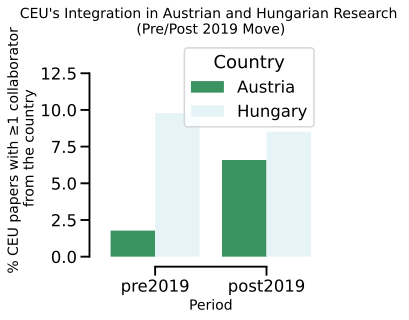

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec

# Data
stats = {
    'Austria': {
        'pre2019': {'fraction': 0.017756604590731917, 'total_papers': 2309, 'papers_with_collaboration': 41},
        'post2019': {'fraction': 0.0658682634730539, 'total_papers': 1503, 'papers_with_collaboration': 99}
    },
    'Hungary': {
        'pre2019': {'fraction': 0.0978778692074491, 'total_papers': 2309, 'papers_with_collaboration': 226},
        'post2019': {'fraction': 0.08516300731869594, 'total_papers': 1503, 'papers_with_collaboration': 128}
    }
}

# Convert data to a DataFrame
data = []
for country in stats:
    for period in stats[country]:
        data.append({
            'Country': country,
            'Period': period,
            'Percentage': stats[country][period]['fraction'] * 100
        })

df = pd.DataFrame(data)

# Custom colors
palette = {"Hungary": "#e5f5f9", "Austria": "#2ca25f"}

# Creating the bar chart
ff = 14
aa=4; bb=4; wspace_=0.5; hspace_=0.3
fig = plt.figure(figsize=(aa, bb))
spec = gridspec.GridSpec(ncols=1, nrows=1, width_ratios=[1], wspace=wspace_, hspace=hspace_, height_ratios=[1])

# Figure
ax = fig.add_subplot(spec[0])
ax = sns.barplot(x='Period', y='Percentage', hue='Country', data=df, palette=palette)
plt.xlabel('Period', fontsize=ff)
plt.ylabel("% CEU papers with ≥1 collaborator \nfrom the country", fontsize=ff)
plt.title("CEU's Integration in Austrian and Hungarian Research \n(Pre/Post 2019 Move)", fontsize=ff)
plt.ylim(0, max(df['Percentage']) + 5)
sns.despine(offset=10, trim=True)

# Show the plot
plt.show()
